# Wine Reviews
Initial exploration to get to know the data.

**Libraries**

In [44]:
import os

# data manipulation libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_theme()

## Data Source
Source: Kaggle [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [45]:
import kagglehub

# Download the dataset if not already downloaded
def load_data(dirname='data', filename='reviews.parquet.gzip'):
  datapath = os.path.join(dirname, filename)
  if os.path.exists(datapath):
    return pd.read_parquet(datapath)
  else:
    os.makedirs(dirname, exist_ok=True)
    path = kagglehub.dataset_download("christopheiv/winemagdata130k")
    fname = 'winemag-data-130k-v2.csv'
    reviews = pd.read_csv(os.path.join(path, fname), index_col=0)
    reviews.to_parquet(datapath, compression='gzip')
    return reviews

reviews = load_data()
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,None,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


**Observations**: Every review has a `title`, `variety`, `description`, and `points` rating.

### Summary of Fields
The dataset contains reviews of wines. The fields can be grouped in the following categories:
- **Subject** *what is being reviewed*: `winery`, `variety`, `vintage` (extracted from `title`), `designation`, `price`
- **Location** *where the wine is from*: `country`, `province`, `region_1`, `region_2`
- **Taster** *who is reviewing the wine*: `taster_name`, `taster_twitter_handle`
- **Review** *the review and rating the wine received*: `description`, and `points`

**Note**: `designation` is typically a brand name a winery may assign to a particular release of a variety to distinguish their products within their portfolio, or across the industry. It is sparsely used, and not relevant to our analysis.

## Understanding the Data
Since the goal of this project is to predict the score a wine should get based on the description that was written, we will begin by understanding the scores. Wine Enthusiast defines scores on a scale from $80$ to $100$, grouped in $6$ ratings ranging from `acceptable` to `classic`.

#### Understanding the point scale
from [WineEnthusiast](https://www.wineenthusiast.com/ratings/)

<p align="center">
<img src="images/points.png" alt="drawing" width="600"/>
</p>

In [46]:
# helper function to plot histograms
def plot_points_distribution(fig, variety = None, ):
  gs = GridSpec(1,2, width_ratios=[1, 2]) # Text column is 1/3, chart is 2/3
  variety_reviews = reviews if variety is None else reviews.query(f'variety == "{variety}"')

  # add text summary
  ax_text = fig.add_subplot(gs[0])
  ax_text.text(0.125, 0.2, f'{variety_reviews.points.mean():.1f} points average', fontsize='small', color='gray',fontname='Arial Unicode MS')
  ax_text.text(0.1, .6, 'All Wines Reviewed' if variety is None else variety, fontsize='x-large', fontname='Sathu')
  ax_text.text(0.125, 0, f'{variety_reviews.points.count()/1000:.1f}k reviews', fontsize='small', color='gray', fontname='Arial Unicode MS')
  ax_text.axis('off')  # Hide axes for the text box

  # Plot histogram and density function
  ax_chart = fig.add_subplot(gs[1])
  ax_chart = sns.barplot(variety_reviews.points.value_counts().reset_index(),x='points',y='count',hue='count', palette='Purples', legend=False, ax=ax_chart, width=1)
  sns.despine(ax=ax_chart)
  ax_chart.set_yticks([])
  ax_chart.set_ylabel(None)
  ax_chart.set_facecolor('white')  
  ax_chart.set_xlabel(None)
  ax_chart.set_xticks(ax_chart.get_xticks())
  ax_chart.set_xticklabels(ax_chart.get_xticklabels(), fontsize='x-small')
  plt.show()

# define the rating bands
rating_bands = [('acceptable',range(80,83)), ('good',range(83,87)), ('very good',range(87,90)), ('excellent',range(90,96)), ('superb',range(96,98)), ('classic',range(98,101))]
ratings = {points: rating for rating, points_range  in rating_bands for points in points_range}

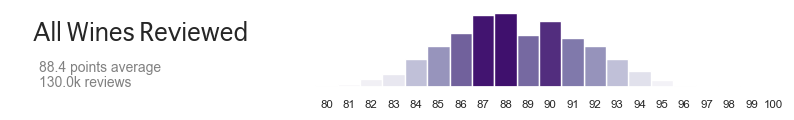

In [47]:
fig = plt.figure(figsize=(10, 1))
# Outer GridSpec (2x2)
plot_points_distribution(fig)

In [48]:
print('only', f'{reviews.query('points > 89').points.count() / reviews.shape[0]:.1%}', 'of wines rated 90+')

only 37.7% of wines rated 90+


**Observations**: $37.7\%$ of wines are rated at or over $90$ points.

#### Understanding Price

In [49]:
reviews.price.describe()

count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

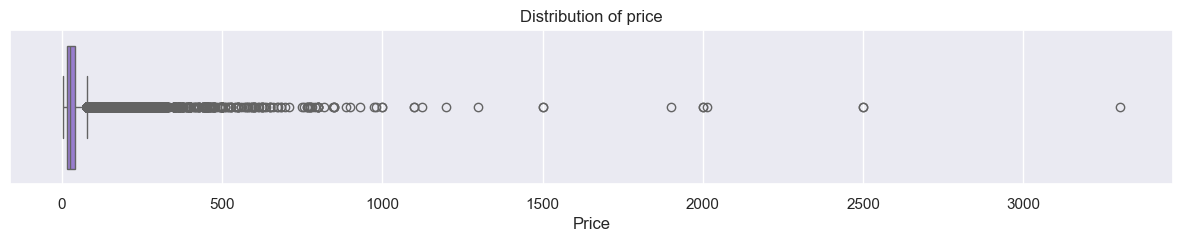

In [50]:
# box plot of price
fig, ax = plt.subplots(figsize=(15, 2))
ax = sns.boxplot(reviews, x='price', orient='h', legend=False, color='mediumpurple')
ax.set_title('Distribution of price')
ax.set_xlabel('Price')
plt.show()

In [51]:
q1 = reviews.price.quantile(0.25)
q3 = reviews.price.quantile(0.75)
iqr = q3-q1
print(
  f'{reviews.query('(price >= @q1 - 1.5*@iqr) and (price <= @q3 + 1.5*@iqr)').price.count() / (reviews.shape[0]-reviews.price.isna().sum()):.1%}', 
  'of prices are between', f'${max(reviews.price.min(),q1-1.5*iqr):.2f}', 'and', f'${q3+1.5*iqr:.2f}'
)
print(f'{reviews.price.isna().sum()/reviews.shape[0]:.1%}', 'of wines reviewed without price')

94.0% of prices are between $4.00 and $79.50
6.9% of wines reviewed without price


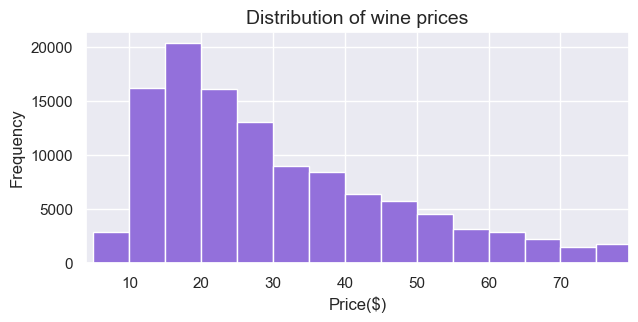

In [52]:
# first look at the distribution of wine prices
plt.figure(figsize=(7,3))
bins = np.arange (0, reviews["price"].max()+5, 5)
plt.hist(data=reviews, x='price', bins=bins, color = 'mediumpurple')
plt.xlim(max(reviews.price.min(),q1-1.5*(q3-q1)), q3+1.5*(q3-q1))
plt.title('Distribution of wine prices', fontsize=14)
plt.xlabel('Price($)')
plt.ylabel('Frequency');

**Observations**: $94.0\%$ of prices are between $\$4.00$ and $\$79.50$. Price can be imputed from *median* of distribution if necessary.

#### Understanding Wine Variety

In [53]:
# count of reviews by varietal
reviews_by_varietal = reviews.groupby('variety')[['title']].count().rename(columns={'title': 'count'}).sort_values('count', ascending=-False)
reviews_by_varietal

,count
variety,
Pinot Noir,13272
Chardonnay,11753
Cabernet Sauvignon,9472
Red Blend,8946
Bordeaux-style Red Blend,6915
...,...
Tempranillo-Malbec,1
Malbec-Carménère,1
Malagouzia-Chardonnay,1


**Observations**: Long tail of infrequent blends, like `Tempranillo-Malbec`. Consider varietals with more than 100 reviews.

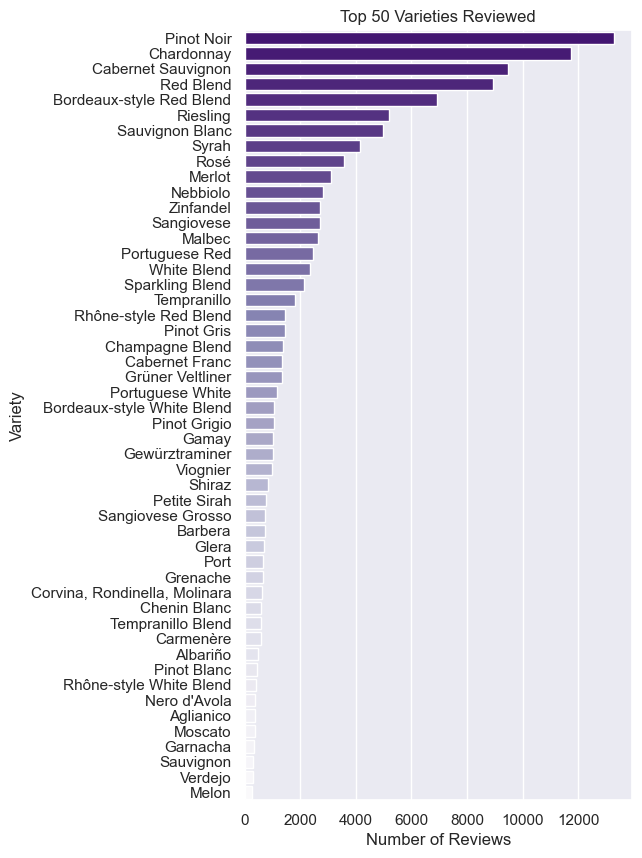

In [54]:
varietals_with_many_reviews = reviews_by_varietal.query('count > 100')
fig = plt.figure(figsize=(5, 10))
n = 50
ax = sns.barplot(varietals_with_many_reviews.head(n), y=varietals_with_many_reviews.head(n).index, x='count', palette='Purples_r', hue='variety', legend=False)
ax.set_title(f'Top {n} Varieties Reviewed')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Variety')
plt.show()

In [55]:
print(f'The top {n} reviewed varieties account for {varietals_with_many_reviews.head(n)["count"].sum():,d} reviews, which is {varietals_with_many_reviews.head(n)["count"].sum()/reviews.shape[0]:.1%} of all the reviews.')

The top 50 reviewed varieties account for 115,439 reviews, which is 88.8% of all the reviews.


In [56]:
# define the white wine varieties
white = {
  'Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Pinot Gris', 'Grüner Veltliner', 'Portuguese White', 
  'Bordeaux-style White Blend', 'Pinot Grigio', 'Gewürztraminer', 'Viognier', 'Glera', 'Chenin Blanc', 'Albariño', 
  'Pinot Blanc', 'Rhône-style White Blend', 'Moscato', 'Sauvignon', 'Verdejo', 'Melon', 'Rosé'
}

# verify that white wine varieties are valid
top_varieties = set(varietals_with_many_reviews.head(n).index.to_list())
assert white.issubset(top_varieties), 'invalid white wine variety'

# define the sparkling wine varieties
sparkling = {'Sparkling Blend', 'Champagne Blend'}

# verify that sparkling wine varieties are valid
assert sparkling.issubset(top_varieties), 'invalid sparkling wine variety'

# remaining wines are all red wines
red = top_varieties - white - sparkling

# verify that red wine varieties are valid
assert red.union(white).union(sparkling) == top_varieties, 'invalid red wine variety'

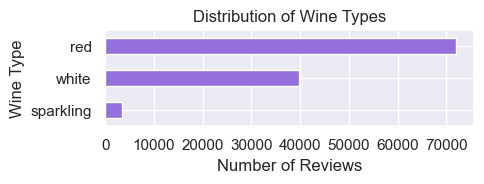

In [57]:
wine_type_mapping = {variety: wine_type for wine_type, varieties in [('white', white), ('red', red), ('sparkling', sparkling)] for variety in varieties}

wine_types = reviews.variety.map(wine_type_mapping)

fig = plt.figure(figsize=(5, 2))
wine_types.value_counts().sort_values(ascending=True).plot(kind='barh', color='mediumpurple')
plt.title('Distribution of Wine Types')
plt.xlabel('Number of Reviews')
plt.ylabel('Wine Type')
plt.tight_layout()
plt.show()

#### Understanding country of origin

54,504 (41.9%) reviews are for wines made in the US.


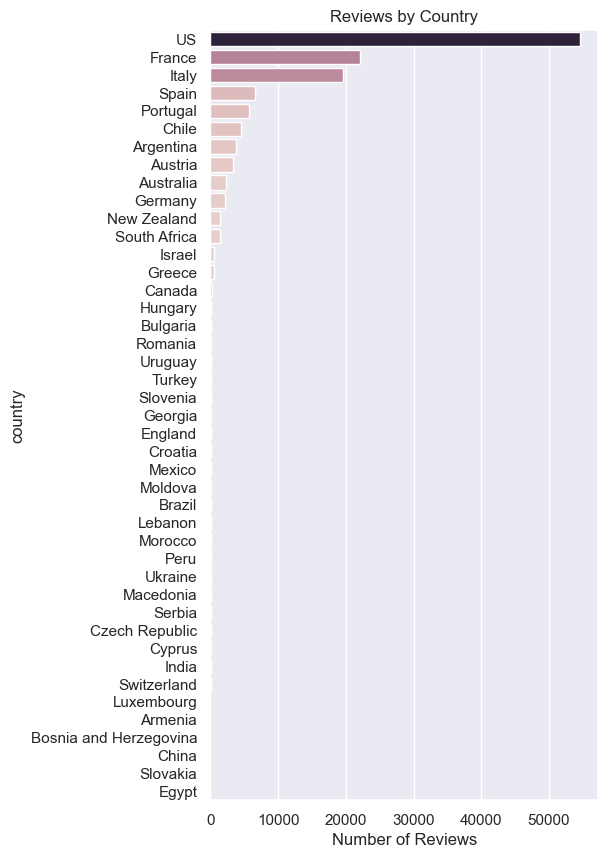

In [58]:
# count reviews by country
reviews_by_country = reviews.groupby('country')[['title']].count().rename(columns={'title':'count'}).reset_index().sort_values('count', ascending=False)

print(f'{reviews_by_country.query('country == "US"')['count'].values[0]:,.0f}', f'({reviews_by_country.query('country == "US"')['count'].values[0]/reviews.shape[0]:.1%})','reviews are for wines made in the US.')

# plot the count of reviews by countries
fig = plt.figure(figsize=(5,10))
ax = sns.barplot(reviews.groupby('country')[['title']].count().rename(columns={'title':'count'}).reset_index().sort_values('count', ascending=False), y='country', x='count', hue='count', legend=False)
ax.set_title(f'Reviews by Country')
ax.set_xlabel('Number of Reviews')
plt.show()

**Observations**: Long tail of countries with few wine reviews. Consider a cutting-off at countries with $200$ or more reviews.

In [59]:
cut_off = 200
print(f'The top {reviews_by_country.query(f"count > {cut_off}").shape[0]} countries with wines reviewed account for {reviews_by_country.query(f"count > {cut_off}")["count"].sum():,d} reviews, or {reviews_by_country.query(f"count > {cut_off}")["count"].sum()/reviews.shape[0]:.1%} of all reviews.')
top_countries = reviews_by_country.query(f'count > {cut_off}').country.to_numpy(dtype=str)
top_countries

The top 15 countries with wines reviewed account for 128,632 reviews, or 99.0% of all reviews.


array(['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina',
       'Austria', 'Australia', 'Germany', 'New Zealand', 'South Africa',
       'Israel', 'Greece', 'Canada'], dtype='<U12')

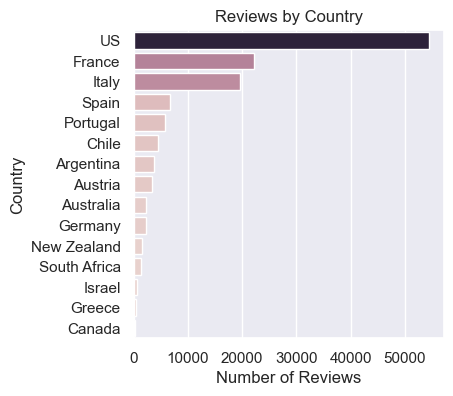

In [60]:
# plot the count of reviews by countries
fig = plt.figure(figsize=(4,4))
ax = sns.barplot(reviews.query('country in @top_countries').groupby('country')[['title']].count().rename(columns={'title':'count'}).reset_index().sort_values('count', ascending=False), y='country', x='count', hue='count', legend=False)
ax.set_title(f'Reviews by Country')
ax.set_ylabel('Country')
ax.set_xlabel('Number of Reviews')
plt.show()

#### Understanding the title

All reviews have a title. The title appears to contain additional useful information, specifically the `vintage` year.

In [61]:
# use regex to extract vintage year from title field
import re
title_pattern = re.compile(r'\D(19[0-9]{2}|20[0-9]{2})')
title = reviews.loc[0, 'title']
m = title_pattern.findall(title)
print(f'The vintage year "{m[-1]}" is extracted from the title "{title}".')

The vintage year "2013" is extracted from the title "Nicosia 2013 Vulkà Bianco  (Etna)".


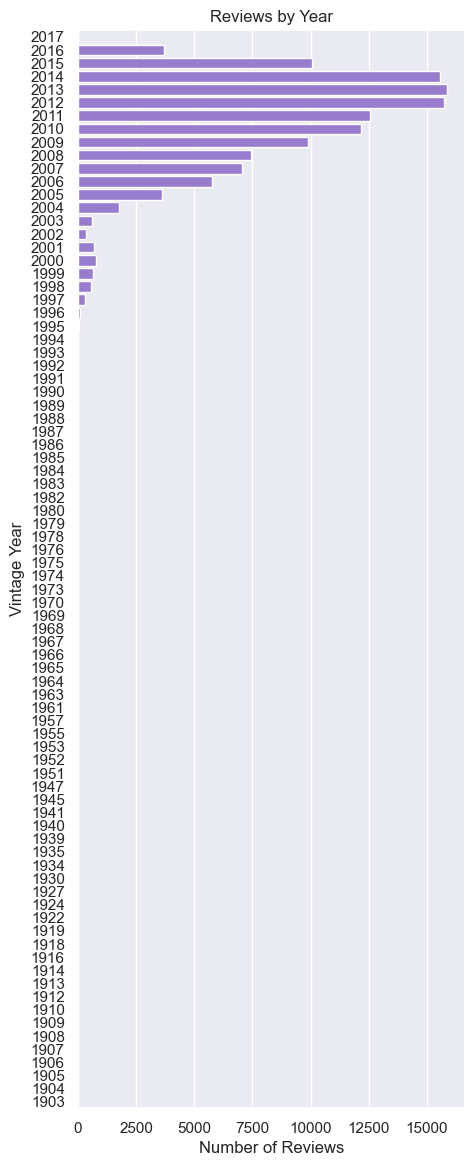

In [62]:

vintage = reviews['title'].apply(func=lambda x: title_pattern.findall(x)[-1] if title_pattern.findall(x) else None)
vintage.dropna(inplace=True)
vintage = vintage.astype(int)
vintage.name = 'year'
vintage = vintage.to_frame()

# plot the count of reviews by vintage year
fig = plt.figure(figsize=(5,14))
# ax = sns.barplot(data=vintage, y='year', x='year', color='mediumpurple', order=vintage['year'].value_counts().index)
ax = sns.countplot(data=vintage, y='year', color='mediumpurple', order=vintage['year'].value_counts().sort_index(ascending=False).index)
ax.set_title(f'Reviews by Year')
ax.set_ylabel('Vintage Year')
ax.set_xlabel('Number of Reviews')
plt.show()

**Observations**: Long tail of vintages with few wine reviews. Consider a focusing on vintages from $2004$ or newer.

In [63]:
print(f'{vintage.query('year >= 2003').year.count() / reviews.shape[0]:.1%}', 'of the wines reviewed are from 2003 or later')

93.7% of the wines reviewed are from 2003 or later


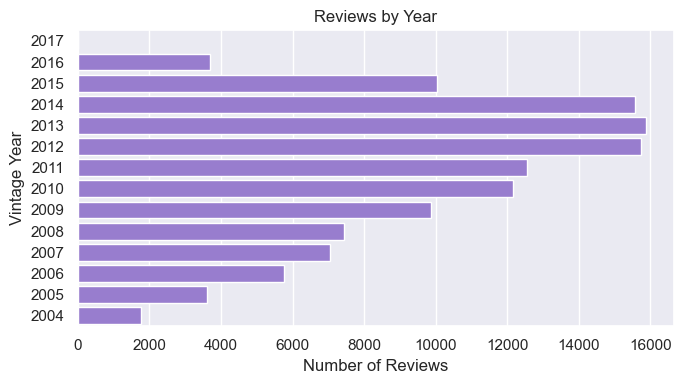

In [64]:
# plot the count of reviews by vintage year
fig = plt.figure(figsize=(7,4))
# ax = sns.barplot(data=vintage, y='year', x='year', color='mediumpurple', order=vintage['year'].value_counts().index)
ax = sns.countplot(data=vintage.query('year > 2003'), y='year', color='mediumpurple', order=vintage.query('year>2003')['year'].value_counts().sort_index(ascending=False).index)
ax.set_title(f'Reviews by Year')
ax.set_ylabel('Vintage Year')
ax.set_xlabel('Number of Reviews')
plt.tight_layout()
plt.show()

In [65]:
# how many wines were reviewed multiple times
reviews['year'] = reviews['title'].apply(func=lambda x: title_pattern.findall(x)[-1] if title_pattern.findall(x) else None)
print(reviews.year.notna().sum())
print(f'{reviews[reviews.year.notna()].groupby(['winery', 'variety', 'year', 'country']).count()[['description']].reset_index().query('description == 1')[['description']].count().iloc[0] / reviews.year.notna().sum():.1%}', 'wines are only reviewed once')
print(f'{reviews[reviews.year.notna()].groupby(['winery', 'variety', 'year', 'country']).count()[['description']].reset_index().query('description > 2')[['description']].count().iloc[0] / reviews.year.notna().sum():.1%}', 'wines are only more than twice')

125345
53.6% wines are only reviewed once
5.4% wines are only more than twice


#### Understanding Winery Location Fields

In [66]:
reviews[['winery', 'country', 'province', 'region_1', 'region_2']].describe()

,winery,country,province,region_1,region_2
count,129971,129908,129908,108724,50511
unique,16757,43,425,1229,17
top,Wines & Winemakers,US,California,Napa Valley,Central Coast
freq,222,54504,36247,4480,11065


In [67]:
reviews[['winery', 'country', 'province', 'region_1', 'region_2']].head()

,winery,country,province,region_1,region_2
0,Nicosia,Italy,Sicily & Sardinia,Etna,None
1,Quinta dos Avidagos,Portugal,Douro,None,None
2,Rainstorm,US,Oregon,Willamette Valley,Willamette Valley
3,St. Julian,US,Michigan,Lake Michigan Shore,None
4,Sweet Cheeks,US,Oregon,Willamette Valley,Willamette Valley


In [68]:
reviews[reviews.province == 'Other'][['winery', 'country', 'province', 'region_1', 'region_2']].head()

,winery,country,province,region_1,region_2
16,Felix Lavaque,Argentina,Other,Cafayate,None
183,Alamos,Argentina,Other,Salta,None
245,Finca Las Moras,Argentina,Other,San Juan,None
728,Terrazas de Los Andes,Argentina,Other,Salta,None
735,El Esteco,Argentina,Other,Calchaquí Valley,None


**Conclusions**: Most reviews have winery, country, and province values. `region_2` is not useful. `region_1` fields may be useful in identifying wine growing regions in certain parts of the world. The winery will be primarily located based on country, and province. The wine region information contained in the fields `province`, `region_1` and `region_2` will be reduced into a single `location` field.

#### Understanding the Wine Designation

In [69]:
reviews[['winery', 'variety', 'designation']].describe()

,winery,variety,designation
count,129971,129970,92506
unique,16757,707,37979
top,Wines & Winemakers,Pinot Noir,Reserve
freq,222,13272,2009


In [70]:
reviews[['winery', 'variety', 'designation']].head()

,winery,variety,designation
0,Nicosia,White Blend,Vulkà Bianco
1,Quinta dos Avidagos,Portuguese Red,Avidagos
2,Rainstorm,Pinot Gris,None
3,St. Julian,Riesling,Reserve Late Harvest
4,Sweet Cheeks,Pinot Noir,Vintner's Reserve Wild Child Block


In [71]:
print(f'{reviews.designation.isna().sum()/reviews.shape[0]:.1%}', 'of the reviews are missing designation')

28.8% of the reviews are missing designation


**Conclusions**: `Designation` appear to be winery branded names and labels for the wine with too many unique values despite almost $30\%$ of the wines reviewed missing a designation. Not useful in classification. Not worth imputing.

#### Understanding Taster information

Taster name and twitter handles are provided for some of the reviews.

In [72]:
reviews[reviews.taster_name.notna()][['title', 'taster_name', 'taster_twitter_handle']]

,title,taster_name,taster_twitter_handle
0,Nicosia 2013 Vulkà Bianco (Etna),Kerin O’Keefe,@kerinokeefe
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Roger Voss,@vossroger
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Paul Gregutt,@paulgwine
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Alexander Peartree,None
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Paul Gregutt,@paulgwine
...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Anna Lee C. Iijima,None
129967,Citation 2004 Pinot Noir (Oregon),Paul Gregutt,@paulgwine
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Roger Voss,@vossroger
129969,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Roger Voss,@vossroger


In [73]:
# reviews where taster name is provided but no twitter handle
reviews_without_twitter = reviews[reviews.taster_name.notna() & reviews.taster_twitter_handle.isna()][['title', 'taster_name', 'taster_twitter_handle']]
taster_without_twitter = reviews_without_twitter.taster_name.unique()
print(f'{reviews_without_twitter.shape[0]:,d} reviews by {len(taster_without_twitter)} reviewers don\'t have twitter handles')
print(f'{reviews[reviews.taster_name.notna()].shape[0]:,d} reviews ({reviews[reviews.taster_name.notna()].shape[0]/reviews.shape[0]:.1%}) have a taster specified.')
reviews.query('taster_name in @taster_without_twitter').taster_twitter_handle.describe()


4,969 reviews by 3 reviewers don't have twitter handles
103,727 reviews (79.8%) have a taster specified.


count       0
unique      0
top       NaN
freq      NaN
Name: taster_twitter_handle, dtype: object

In [74]:
print(f'{reviews[reviews.taster_name.isna() & reviews.taster_twitter_handle.notna()].shape[0]}', 'review has a twitter handle without a taster name.')

0 review has a twitter handle without a taster name.


**Conclusions**: The `taster_twitter_handle` field can be dropped. Most reviews have a taster provided. Also, missing tasters can be assigned to `Unknown` instead of imputing to most common reviewer. Given the nature of the assigment, this is a better representation.

#### Understanding the Description

This is the key field from which features corresponding to the traits of the wine being reviewed will be extracted. It is expected that patterns of similar words will surface, which will enable an algorithm to predict the quality of wines based on their variety.

**Why the description matters**

Different types of wine are expected to express different types of flavors. Consider `Pinot Noir`, which is a red wine. It is considered a light bodied red wine with black fruit and earthy notes.

<div center="align">
  <img src="images/Pinot-Noir-wine-profile-glass.jpg" alt="wines" height="400"/>
  <img src="images/pinot-noir-flavors.png" alt="pinot noir" height="400"/>
</div>

In [75]:
from IPython.display import Markdown, display

description = reviews.sample(1, random_state=23).description.values[0]

# representative description
display(Markdown('**Sample Description:**' + '\n\n'+ f'{description}'))

**Sample Description:**

For an affordable, ready-to-drink bottling, this twist-top wine, which gets a touch of Sémillon, shows ripe nectarine, Pink Lady apple, lime water and grapefruit pith on the nose. The palate offers baking soda and lemon-lime flavors, along with tart apple skins and grassy notes.

**Exploring the nature of the descriptions**

In [76]:
reviews.description.describe()

count                                                129971
unique                                               119955
top       Seductively tart in lemon pith, cranberry and ...
freq                                                      3
Name: description, dtype: object

**Observations**: There are duplicate descriptions.

In [77]:
reviews['review_len'] = reviews.description.str.len()
reviews.review_len.describe()

count    129971.000000
mean        242.601065
std          66.584276
min          20.000000
25%         197.000000
50%         237.000000
75%         282.000000
max         829.000000
Name: review_len, dtype: float64

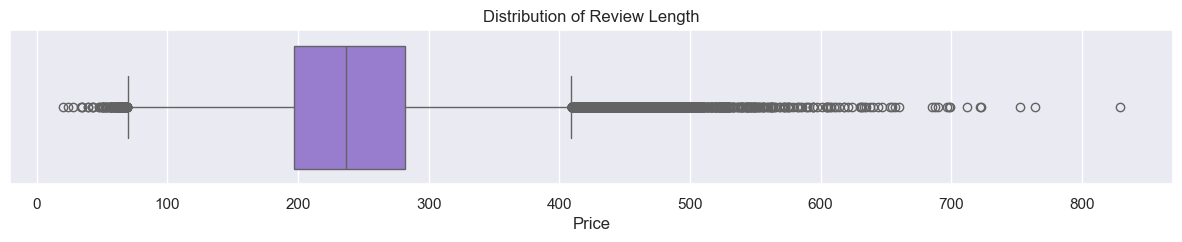

In [78]:
# box plot of review length
fig, ax = plt.subplots(figsize=(15, 2))
ax = sns.boxplot(reviews, x='review_len', orient='h', legend=False, color='mediumpurple')
ax.set_title('Distribution of Review Length')
ax.set_xlabel('Price')
plt.show()

**Observations**: $50\%$ of the reviews are between $200$ and $280$ characters long.

**Extract Features from Text Description**

Use natural language processing to extract features, e.g. vector of words, from description.

Vector of words extracted from the description:
--------------------------------------------------
{'apple': 1.0, 'lime': 1.0, 'affordable': 0.5, 'ready': 0.5, 'bottling': 0.5, 'twist': 0.5, 'top': 0.5, 'gets': 0.5, 'touch': 0.5, 'Sémillon': 0.5, 'shows': 0.5, 'ripe': 0.5, 'nectarine': 0.5, 'Pink': 0.5, 'Lady': 0.5, 'water': 0.5, 'grapefruit': 0.5, 'pith': 0.5, 'nose': 0.5, 'palate': 0.5, 'offers': 0.5, 'baking': 0.5, 'soda': 0.5, 'lemon': 0.5, 'along': 0.5, 'tart': 0.5, 'skins': 0.5, 'grassy': 0.5, 'notes': 0.5}
--------------------------------------------------


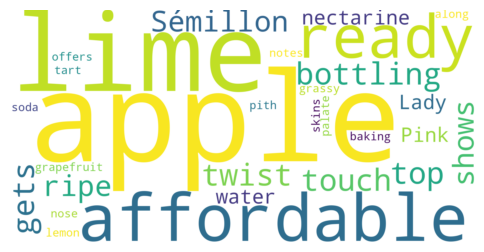

In [79]:
import wordcloud as wc

# helper Function for display frequency of words
def freq_words(words, title=None, show_v=False):
  '''
  Show frequency of words as an image
  '''

  stopwords = set(wc.STOPWORDS)
  stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

  # Generate frequency of words as an image
  freq_words_img = wc.WordCloud(stopwords=stopwords, background_color='white', width=2048,height=1024, max_words=1000).generate(words)

  # print the vector of words extracted from the description
  if show_v:
    print('Vector of words extracted from the description:')
    print('--------------------------------------------------')
    print(freq_words_img.words_)
    print('--------------------------------------------------')

  # Display the image
  plt.figure(figsize=(6,6))
  if title is not None:
    plt.title(title)
  plt.imshow(freq_words_img, interpolation="bilinear")
  plt.axis("off")
  plt.show()

# show a word cloud of the features extracted from the description
freq_words(description, show_v=True)

**Most common words across ALL wine reviews**

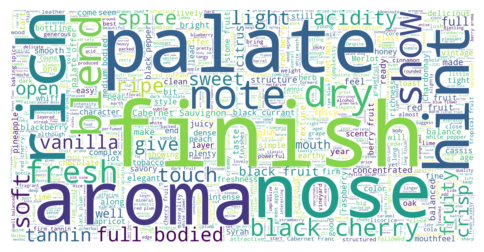

In [80]:
# generate a word cloud of the features extracted from all the descriptions
freq_words(' '.join(reviews.description))

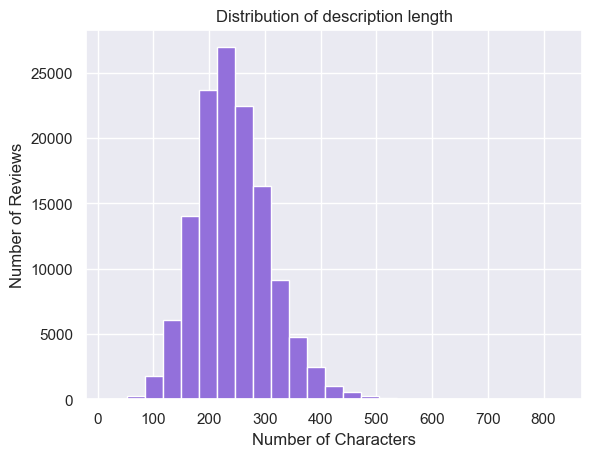

In [81]:
reviews.description.apply(len).plot(kind='hist', bins=25, color='mediumpurple')
plt.title('Distribution of description length')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Reviews')
plt.show()

In [82]:
print(f'{reviews[reviews.description.apply(len) > 275].shape[0]/reviews.shape[0]:.1%}', 'of the reviews have a description longer than 275 characters.')

28.1% of the reviews have a description longer than 275 characters.


## Missing Data

In [83]:
reviews.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
year                      4626
review_len                   0
dtype: int64

**Observations**:
- $63$ reviews are missing `country` or `province`. These can likely be imputed since $42\%$ of the wines are from the US.
- No missing `winery`, `title`, `description`, or `points`, since these are the critical elements of the wine review.
- $7\%$ of the wines are missing `price`. Missing `'price` values can be imputed from the *median* value if necessary.
- the `province`, `region_1`, and `region_2` fields will be consolidated so that and should nmot result in missing fields.
- `taster_twitter_handle` is redundant with `taster_name` and will be dropped. $20\%$ of the reviews are missing `taster_name`. Given the nature of this project, missing values will be set to **Unknown**
- Only $1$ review is missing `variety`. Without knowing what is being reviewed, this sample will be dropped.
- As mentioned before, too many `designation` values, with too large number of distinct values when it exists. This field represents a brand name and is not useful for this project.

## Duplicate Data

In [84]:
description_stats = reviews.description.describe()
description_stats

count                                                129971
unique                                               119955
top       Seductively tart in lemon pith, cranberry and ...
freq                                                      3
Name: description, dtype: object

In [85]:
print(f'{reviews.shape[0] - description_stats["unique"]:,.0f}', f'({(reviews.shape[0] - description_stats["unique"])/reviews.shape[0]:.1%})', 'of the review descriptions are duplicates')

10,016 (7.7%) of the review descriptions are duplicates


**Examining one of the duplicate review descriptions**

In [86]:
reviews[reviews.description.str.contains('Seductively tart in lemon pith, cranberry and')]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,review_len
12141,US,"Seductively tart in lemon pith, cranberry and ...",Woods Vineyard Rosé of,91,29.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Ousterhout 2014 Woods Vineyard Rosé of Pinot N...,Pinot Noir,Ousterhout,2014,264
51822,US,"Seductively tart in lemon pith, cranberry and ...",800 Vines Jenna's Vineyard Rosé of,89,25.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Ousterhout 2014 800 Vines Jenna's Vineyard Ros...,Pinot Noir,Ousterhout,2014,264
119866,US,"Seductively tart in lemon pith, cranberry and ...",800 Vines Jenna's Vineyard Rosé of,89,25.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Ousterhout 2014 800 Vines Jenna's Vineyard Ros...,Pinot Noir,Ousterhout,2014,264


**Observations**: $2$ different wines reviewed by the same taster, one of them twice. The wine reviewed twice was granted the same consistent score, perhaps indicating that the review was published twice. However, it is not clear why the same review description is used for a different wine, eventhough it is from the same winery. Will remove duplicates, and keep *last* value.

**Observations**

$7.7\%$ of the reviews are duplicated. To reduce confusing the learning algorithms, duplicates will be dropped.

## Summary

The data cleaning strategy will be to:
1. select reviews from the top $50$ wine varieties,
1. select reviews from countries with more than $200$ reviews,
1. drop reviews missing `variety`
1. from a vintage newer than $2003$
1. drop duplicate `descriptions`
1. drop the following fields: `price`, `province`, `region_1`, `region_2`, `taster_twitter_handle`, and `designation`
1. set missing `taster_name` to **Unknown**

## Next
- [Data Cleaning](data_cleaning.ipynb)